In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


In [12]:
df = pd.read_csv('/content/cluster_data.csv')
df.head()

,Feature 1,Feature 2
0,2.698582,-0.672960
1,-0.128113,4.355952
2,2.509049,5.773146
3,-1.518276,3.444886
4,-0.072283,2.883769


In [13]:
print("Missing values:\n", df.isnull().sum())
print("Duplicates:", df.duplicated().sum())

Missing values:
 Feature 1    0
Feature 2    0
dtype: int64
Duplicates: 0


In [14]:
def cap_outliers_iqr(df_in, cols, k=1.5):
    df_out = df_in.copy()
    for c in cols:
        Q1 = df_out[c].quantile(0.25)
        Q3 = df_out[c].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR
        df_out[c] = df_out[c].clip(lower, upper)
    return df_out

numeric_cols = df.select_dtypes(include='number').columns.tolist()
df_capped = cap_outliers_iqr(df, numeric_cols)

In [15]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df_capped[numeric_cols]), columns=numeric_cols)



Best k by silhouette score: 2


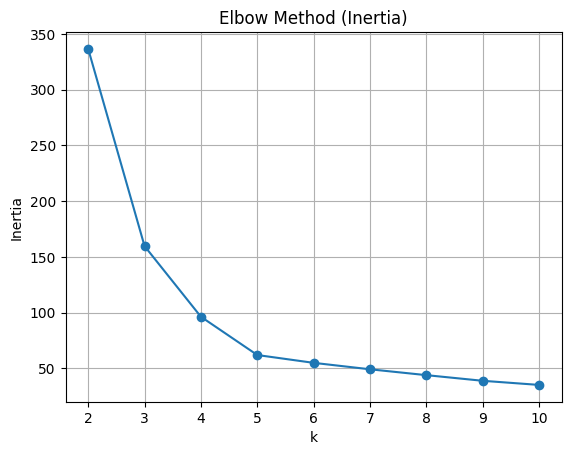

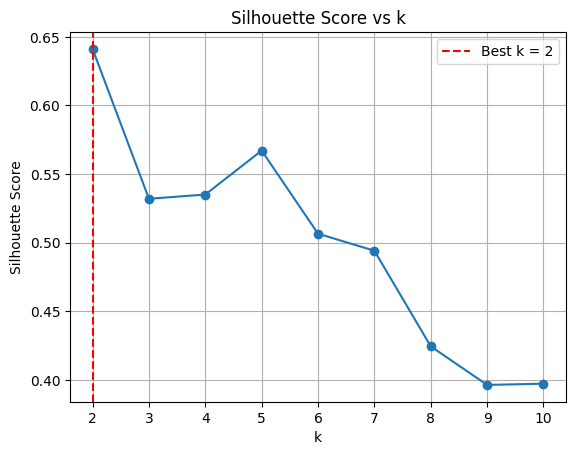

In [16]:
ks = range(2, 11)
inertias = []
sil_scores = []

for k in ks:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

best_k = ks[sil_scores.index(max(sil_scores))]
print("\nBest k by silhouette score:", best_k)
plt.figure()
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(ks, sil_scores, marker='o')
plt.axvline(best_k, color='r', linestyle='--', label=f"Best k = {best_k}")
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
labels_km = kmeans.fit_predict(X_scaled)
sil = silhouette_score(X_scaled, labels_km)
print("Silhouette score (KMeans):", round(sil, 4))

unique, counts = np.unique(labels_km, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")


Silhouette score (KMeans): 0.6412
Cluster 0: 396 samples
Cluster 1: 104 samples


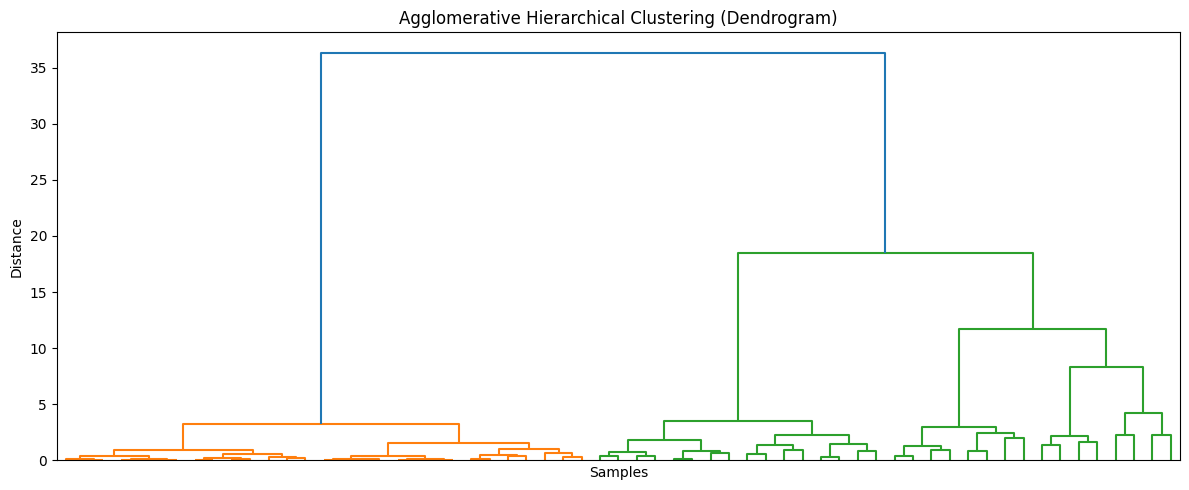

In [18]:
Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode="level", p=5, no_labels=True)
plt.title("Agglomerative Hierarchical Clustering (Dendrogram)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [19]:
def bisecting_kmeans_tree(X, k=2, random_state=42, n_init=10):
    clusters = {0: X.index}
    next_id = 1
    tree = []
    labels = pd.Series(np.zeros(len(X), dtype=int), index=X.index)

    while len(clusters) < k:
        to_split = max(clusters, key=lambda cid: len(clusters[cid]))
        idx = clusters[to_split]
        km = KMeans(n_clusters=2, n_init=n_init, random_state=random_state).fit(X.loc[idx])
        left_idx = idx[km.labels_ == 0]
        right_idx = idx[km.labels_ == 1]

        left_id = next_id
        right_id = next_id + 1
        next_id += 2

        clusters[left_id] = left_idx
        clusters[right_id] = right_idx
        del clusters[to_split]

        labels[left_idx] = left_id
        labels[right_idx] = right_id
        tree.append((to_split, left_id, right_id))

    remap = {old: new for new, old in enumerate(sorted(clusters))}
    final_labels = labels.map(remap)

    return final_labels, tree

labels_div, tree_div = bisecting_kmeans_tree(X_scaled, k=best_k)
print("\nCluster sizes (Bisecting KMeans):")
print(labels_div.value_counts().sort_index())
print("\nTree Structure (parent → left, right):")
for p, l, r in tree_div:
    print(f"{p} → {l}, {r}")


Cluster sizes (Bisecting KMeans):
0    396
1    104
Name: count, dtype: int64

Tree Structure (parent → left, right):
0 → 1, 2


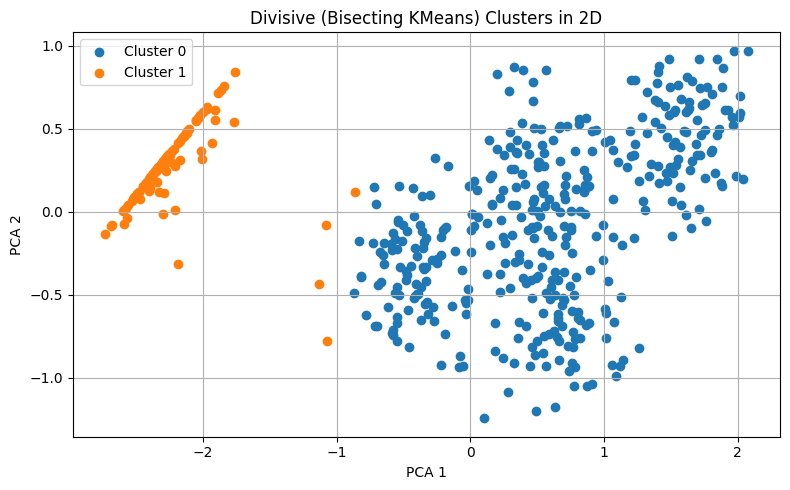

In [20]:
# === 11. PCA for Visualization (2D) ===
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

# --- Plot Bisecting KMeans ---
plt.figure(figsize=(8, 5))
for label in np.unique(labels_div):
    plt.scatter(
        X_2d[labels_div == label, 0],
        X_2d[labels_div == label, 1],
        label=f"Cluster {label}"
    )
plt.title("Divisive (Bisecting KMeans) Clusters in 2D")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

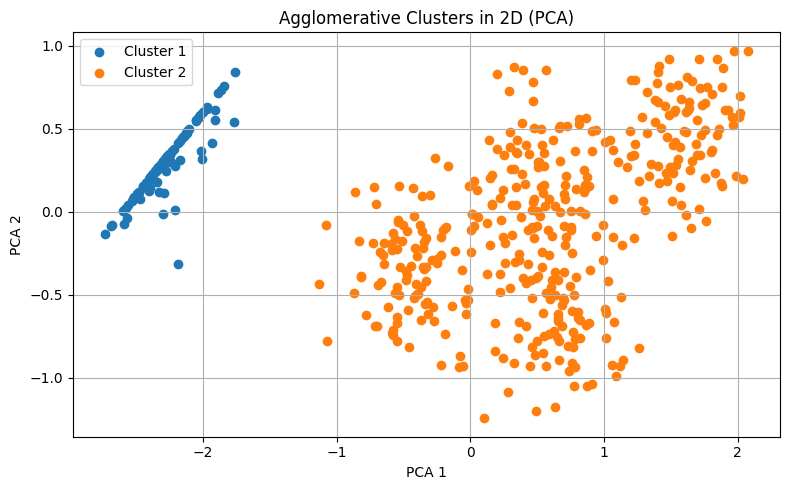

In [21]:
# --- Plot Agglomerative Clusters ---
agglo_labels = fcluster(Z, t=best_k, criterion='maxclust')
plt.figure(figsize=(8, 5))
for label in np.unique(agglo_labels):
    plt.scatter(
        X_2d[agglo_labels == label, 0],
        X_2d[agglo_labels == label, 1],
        label=f"Cluster {label}"
    )
plt.title("Agglomerative Clusters in 2D (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()